In [1]:
#define path
wesley_ds = "/files"
kaggle_ds = "/archive/Data/genres_original"
main_path = "../raw_dataset"

In [2]:
#choose the dataset
chooser = wesley_ds

In [3]:
DATASET_PATH = main_path+chooser
# DATASET_PATH = "../../../Music"
JSON_PATH = '../pr_dataset/myjson2.json'
SAMPLE_RATE = sr =  22050
DURATION = 30 #measured in seconds 
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(main_path+chooser):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        print(filename)
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
# from tqdm import tqdm 
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
import os
import math
import json
import random

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    #dictionary to store data
    data = {
        'mapping' : [],
        'mfcc' : [],
        'labels' : []
    }
    
    count = 0 # To keep track of our progress
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    #Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not at the root level
        if dirpath not in dataset_path:

            #save the semantic label
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data['mapping'].append(semantic_label)
            print('\nProcessing {}'.format(semantic_label))
            
            #process files for a specific genre 
            for f in filenames:
#                 if f.endswith('.wav') and f != 'jazz.00054.wav': # Since file jazz.00054.wav is an empty file
                if True: # Since file jazz.00054.wav is an empty file
                    file_path = os.path.join(dirpath,f)
                    
                    #loading the audio file 
                    # we are using the soundfile library since it is faster than librosa
                    signal, sr = librosa.load(file_path) # len(signal) = 661794  # sr is 22050 by default 
                    midptr = int(signal.shape[0]/2)
                    bptr = midptr - (SAMPLE_RATE*DURATION) #set as OFFSET
#                     hptr = midptr + (SAMPLE_RATE*duration)
                    #print(signal,sr)
                    #process segments extracting mfcc and storing data
                    for s in range(num_segments): 
                        # Since num_segments is defined as 5. Every 30 sec file is divided into 5 segments of length 6sec 
                        # Start sample would keep track of the index of the first element of each 6 second batch
                        # finish sample would keep track of the index of the last element of each 6 second batch
                        # And then with the help of python's slice functionality we will extract that 6 second batch from every 30 sec signal
                        start_sample = bptr + num_samples_per_segment * s   
                        finish_sample = num_samples_per_segment + start_sample
                        
                        # Next, we will pass each segment in order to extract MFCC. The parameter n_mfcc defines the number of mfcc 
                        # we need to extract, Usually n_mfcc is set b/w 13 to 40. The other parameters n_fft and hop length are 
                        # indivisual topics of discussion. Will be discussed in later Notbooks. 
                        mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],
                                                   sr = sr,
                                                   n_fft = n_fft,
                                                   n_mfcc = n_mfcc,
                                                   hop_length = hop_length)

                        mfcc = mfcc.T
                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            print(mfcc.shape)
                            data['mfcc'].append(mfcc.tolist())
                            data['labels'].append(i)
                            print('Processing {}, segment:{}'.format(file_path, s))
                            count += 1
                            print(count)
    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [ ]:
# Let's run the above function 
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [5]:
# loading the saved Json file
def load_data(path):
    with open(path, 'r') as fp:
        data = json.load(fp)
        
    #Convert lists into numpy arrays
    inputs = data['mfcc']
    targets = data['labels'] 
    return np.array(inputs), np.array(targets)

In [6]:
inputs, targets = load_data(JSON_PATH)

In [7]:
print(inputs)

[[[ 2.14072616e+01  6.67258947e+01  2.97258605e+01 ... -8.57448504e+00
   -1.57755677e+00 -4.94587338e+00]
  [ 3.07572078e+01  5.23091250e+01  3.89966963e+01 ... -2.12680036e+00
    6.16240602e+00  8.14609254e-01]
  [-5.60983702e+00  1.05013424e+01  4.24299082e+01 ...  1.32480420e+00
    1.33671936e+01  3.76280255e+00]
  ...
  [ 1.39197889e+01  9.06260339e+01  2.07068415e+01 ...  6.09766610e+00
    4.98689832e+00 -4.17833809e+00]
  [-7.90029448e+01  5.14671405e+01  5.52346291e+00 ...  1.09467828e+00
    2.03547542e+01  1.82178077e+01]
  [-1.01789304e+02  2.69560376e+01 -1.43455708e+01 ...  4.34714808e+00
    2.58664966e+01  2.71645234e+01]]

 [[-8.57086022e+01 -1.66599448e+01 -4.00433750e+01 ...  1.46792267e-01
    1.88251551e+01  1.68434966e+01]
  [ 1.01857786e+01 -6.48726464e+01 -5.87159710e+01 ...  4.70629492e+00
    1.64398939e+01  1.58211969e+01]
  [ 3.67405252e+01 -8.48920266e+01 -6.32467712e+01 ... -2.61447730e+00
    7.25607017e+00  8.14229922e+00]
  ...
  [ 1.07602814e+02 -1.0

In [8]:
inputs.shape

(7170, 65, 13)

In [9]:
np.unique(targets, return_counts=True)

(array([1, 2, 3, 4, 5]), array([1100, 3080,  480,  910, 1600], dtype=int64))

In [10]:
# Converting labels from 15-24 to 0-9
v = min(np.unique(targets))
for i in range(len(targets)):
    if targets[i] == v:
        targets[i] = 0
    else:
        new = targets[i] - v
        targets[i] = new

In [11]:
np.unique(targets, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1100, 3080,  480,  910, 1600], dtype=int64))

In [12]:
# tss = TimeSeriesSplit()
# for train_index, test_index in tss.split(inputs):
#     print(train_index, test_index)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2)
inputs_train[1].shape

(65, 13)

In [13]:
# Adding Noise 
for i in range(inputs_train.shape[0]):
    s = np.random.rand(inputs_train.shape[1], inputs_train.shape[2])
    inputs_train[i] = inputs_train[i] + s

In [49]:
model = Sequential()


model.add(GRU(500, input_shape=(inputs.shape[1], inputs.shape[2])))

# model.add(GRU(100, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
# model.add(GRU(200, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(GRU(200))

model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Dense(5, 'sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])



model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 500)               772500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 2505      
Total params: 775,005
Trainable params: 775,005
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(inputs_train, targets_train,
          validation_data=(inputs_test, targets_test),
          epochs = 35,
          batch_size=100)

Train on 5736 samples, validate on 1434 samples
Epoch 1/35
5736/5736 [==============================] - 5s 906us/sample - loss: 1.3984 - accuracy: 0.4250 - val_loss: 1.2526 - val_accuracy: 0.4742
Epoch 2/35
5736/5736 [==============================] - 2s 390us/sample - loss: 1.2424 - accuracy: 0.4573 - val_loss: 1.1848 - val_accuracy: 0.4888
Epoch 3/35
5736/5736 [==============================] - 2s 391us/sample - loss: 1.1612 - accuracy: 0.4930 - val_loss: 1.1358 - val_accuracy: 0.5216
Epoch 4/35
5736/5736 [==============================] - 2s 387us/sample - loss: 1.0630 - accuracy: 0.5589 - val_loss: 1.0720 - val_accuracy: 0.5614
Epoch 5/35
5736/5736 [==============================] - 2s 390us/sample - loss: 0.9677 - accuracy: 0.6016 - val_loss: 1.0082 - val_accuracy: 0.5872
Epoch 6/35
5736/5736 [==============================] - 2s 392us/sample - loss: 0.8437 - accuracy: 0.6522 - val_loss: 0.9284 - val_accuracy: 0.6374
Epoch 7/35
5736/5736 [==============================] - 2s 396us

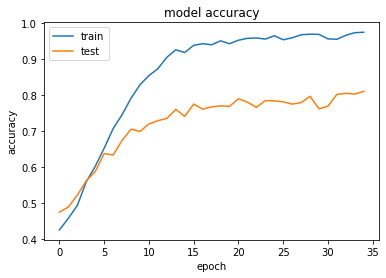

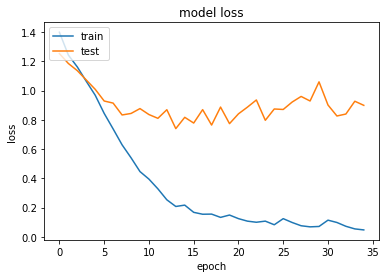

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#Fine-tuning

model.add(Dense(5, 'sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predictions_one_hot = model.predict(inputs_test)
print(targets_test.shape, predictions_one_hot.shape)
# cm = confusion_matrix(targets_test, predictions_one_hot.argmax(axis=1))
# print(cm)
con_mat = tf.math.confusion_matrix(labels=targets_test, predictions=predictions_one_hot.argmax(axis=1)).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1,2,3,4], 
                     columns = [0,1,2,3,4])
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [3]:
signal, sr = librosa.load("../raw_dataset/files/BIG ROOM/01 Agus Zack _ Devbanz - Workout (Extended M.mp3") # len(signal) = 661794  # sr is 22050 by default 

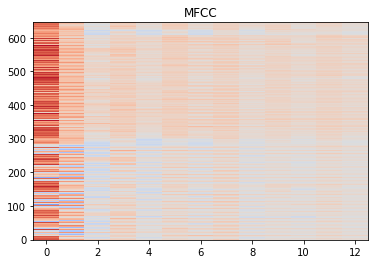

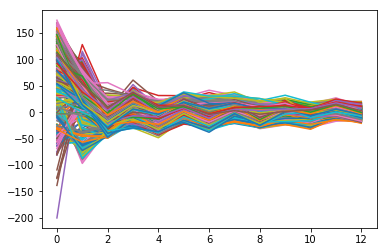

In [4]:
signal.shape[0]
mfcc = librosa.feature.mfcc(signal[0 : 22050*30],
                                                   sr = 22050,
                                                   n_fft = 4084,
                                                   n_mfcc = 13,
                                                   hop_length = 1024)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# (rate,sig) = wav.read("file.wav")
mfcc_feat = mfcc

ig, ax = plt.subplots()
mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
#Showing mfcc_data
plt.show()
#Showing mfcc_feat
plt.plot(mfcc_feat)
plt.show()

In [6]:
mfcc.shape

(13, 646)